In [6]:
# Se importa el módulo request para realizar solicitudes HTTP
import requests
# Se importa el módulo Json para trabajar y manipular datos en formato Json
import json
# Se importa el módulo re para trabajar con secuencias de caracteres y cadenas de texto
import re
#Se importa la función get_installed_software de la biblioteca windows_tools para obtener 
#los softwares instalados en el sistema
from windows_tools.installed_software import get_installed_software
# Se importa la clase cosmosClient desde el azure.cosmos 
from azure.cosmos import CosmosClient

# Se configura la cadena de conexión y los datos necesarios para realizar la conexión con Cosmos DB
endpoint = "tu cadena de conexión" # Es la cadena de conexión de cosmos db
key = "tu clave" # Es la clave de acceso a la base de datos
database_name = "SoftwareVulnerability" # Es el nombre de la base de datos donde se guarda la información
container_name = "Softwares" # Es el contenedor de la base de datos donde se guarda la información

# Se crea una instancia de cosmosClient
client = CosmosClient(endpoint, key)

# Se obtiene la base de datos "SoftwareVulnerability"
database = client.get_database_client(database_name)

# Se obtiene el contenedor "Softwares"
container = database.get_container_client(container_name)

# Se define una función que recibe los nombres de los softwares como entrada
# para obtener el nombre del software eliminando la versión y el tipo de sistema
def preprocessName(name):
    # Se elimina cualquier secuencia de caracteres entre paréntesis y dígitos
    name = re.sub(r'\(.*?\)|\d', '', name)
    # Se eliminan los espacios en blanco del nombre
    name = name.strip()
    return name

# Se define una función que recibe el nombre del software y la apikey como entrada
# para obtener información sobre las vulnerabilidades de cada software
def postVuldbData(software, apikey):
    # Se define la url de la api y se asigna la apikey recibida 
    url = 'https://vuldb.com/?api'
    apiKey = apikey
    # Se definen los parámetros de la solicitud HTTP
    params = {
        'apikey': apikey, 
        'search': software, 
        'sort': 'vulnerability' 
    }
    
    try:
        # Se realiza una solicitud post a la api con los parámetros definidos
        response = requests.post(url, data=params)
        # Se verifica si la solicitud fue exitosa
        if response.status_code == 200:
            # En caso de que si se convierte la respuesta json en un diccionario python
            data = response.json()
            return data
        else:
            # En caso de que no, se muestra un mensaje de error
            print('Error al obtener datos de la API. Código de estado:', response.status_code)
            return None
    #Captura cualquier excepción presentada durante la solicitud y muestra un mensaje de error
    except Exception as e:
        print('Error al realizar la solicitud a la API:', e)
        return None

# Se define una función que recibe los datos de la api como entrada para extraer la información
# relevante de cada resultado
def checkVulns(ipData):
    try:
        # Se verifica si hay datos disponibles
        if ipData:
            # Se inicializa una lista para almacenar la información de las vulnerabilidades
            vulnerabilities = []
            # Se itera sobre los resultados de la api
            for result in ipData.get('result', []):
                # Se verifica si el resultado contiene la información necesaria para una vulnerabilidad válida
                if 'entry' in result and 'vulnerability' in result and 'source' in result and 'cve' in result['source']:
                    # Se extrae la información relevante de cada resultado
                    titulo = result['entry']['title']
                    criticidad = result['vulnerability']['risk'].get('name', 'Desconocida')
                    cve = result['source']['cve']['id']
                    # Se obtiene la descripción de la vulnerabilidad llamando la función vulnsInfo
                    descripcion = vulnsInfo(cve)
                    # Se agrega la información extraida a la lista de vulnerabilidades
                    vulnerabilities.append({'titulo': titulo, 'criticidad': criticidad, 'cve': cve, 'descripcion': descripcion})
            return vulnerabilities
        else:
            # Si no hay datos disponibles se muestra un mensaje y devuleve una lista vacía
            print(f"No se encontraron vulnerabilidades para el software")
            return []
    except Exception as e:
        # Se maneja cualquier exepción que ocurra durante la extracción de los datos
        print(f"Error al obtener vulnerabilidades para el software: {e}")
        return []

# Se define una función que recibe el id del CVE para obtener la descripción de las vulnerabilidades
def vulnsInfo(cve):
    try:
        # Se construye la url que permite consultar la descripción de las vulnerabilidades
        urlCve = "https://cveawg.mitre.org/api/cve/" + str(cve)
        # Se realiza una solicitud get a la url y se convierte la respuesta json en un diccionario de python
        # y se extrae la descripción de la vulnerabilidad
        cveDescription = requests.get(urlCve).json()["containers"]["cna"]["descriptions"][0]["value"]
        return cveDescription
    except Exception as e:
        # Se maneja cualquier excepción qie ocurra durante las extracción de la descripción de las vulnerabilidades
        print(f"Error al obtener los detalles de la CVE-{cve}: {e}")
        return None

# Se define una lista de apikeys para la api vuldb
apiKeys = ['tu apikey', 'tuapikey'] 
# Se define el número máximo de consultas por ciclo de cada apikey
maxNumConsultas = 50
# Se inicializa el contador de consultas 
ContadorConsultas = 0
# Se inicializa el contador de índice de la apikey
indexApiKey = 0

# Se obtiene la información sobre los softwares instalados en el sistema
installedSoftware = get_installed_software()
# Se inicializa un conjunto vacío para almacenar los nombres de los software preprocesados
preprocessedNames = set()

# Se realiza un for para iterar sobre la lista de sofwares instalados
for software in installedSoftware:
    # Se obtiene el nombre del software de cada elemento del diccionario
    name = software['name']
    # Se llama la función que procesa los nombres de los softwares y el nombre procesado se
    # agrega al conjunto de los nombres de software
    preprocessedName = preprocessName(name)
    preprocessedNames.add(preprocessedName)

# Se convierte el conjunto de nombres en una lista y se selecciona el rango que se desee procesar
numSoftwares = list(preprocessedNames)[150:200]

# Se realiza un for para iterar sobre los nombres de los software que estan dentro del rango definido 
for name in numSoftwares:
    # Se verifica si se ha alcanzado el límite máximo de consultas por ciclo
    if ContadorConsultas >= maxNumConsultas:
        # En caso de que si se cambia a la siguiente apikey y se reinicia el contador de consultas
        indexApiKey = (indexApiKey + 1) % len(apiKeys)  
        ContadorConsultas = 0  
    
    # Se llama a la función que consulta la api vuldb para obtener la información sobre
    # las vulnerabilidades del software y se incrementa el contador de consultas
    ipData = postVuldbData(name, apiKeys[indexApiKey])
    ContadorConsultas += 1
    
    # Se llama a la función que extrae la información relevante de cada vulnerabilidad
    vulnerabilities = checkVulns(ipData)
    
    # Si se encuentran vulnerabilidades, se guarda la información en la base de datos
    if vulnerabilities:
        # Se crea un documento json con la información relevante
        data = {
            "id": name,
            "nombre": name,
            "vulnerabilidades": vulnerabilities
        }
        try:
            # Se guarda el documento con las vulnerabilidades del software en un item 
            container.create_item(body=data)
            print(f"Datos guardados correctamente para {name}")
        except Exception as e:
            # Se maneja cualquier excepción que se presente durante el proceso de alamacenamiento de los datos
            print(f"Error al guardar datos para {name} en Cosmos DB: {e}")
    else:
        # Se imprime un mensaje en caso de no encontrar vulnerabilidades para el software
        print(f"No se encontraron vulnerabilidades para {name}")
# Se imprime un mensaje al funalizar el proceso
print("Proceso de guardado en Cosmos DB completado.")

No se encontraron vulnerabilidades para Microsoft .NET . Templates ..
No se encontraron vulnerabilidades para Microsoft.NET.Sdk.Android.Manifest-..
No se encontraron vulnerabilidades para Microsoft Visual C++ - Redistributable  - ..
No se encontraron vulnerabilidades para Opera GX Stable ...
No se encontraron vulnerabilidades para Python ..
No se encontraron vulnerabilidades para vs_FileTracker_Singleton
Datos guardados correctamente para Microsoft SQL Server
Datos guardados correctamente para IBM SPSS Statistics
No se encontraron vulnerabilidades para Microsoft.NET.Sdk.Maui.Manifest-..
No se encontraron vulnerabilidades para Microsoft.NETCore.App.Runtime.Mono.browser-wasm
No se encontraron vulnerabilidades para Microsoft Windows Desktop Targeting Pack - ..
No se encontraron vulnerabilidades para Microsoft ASP.NET Web Tools Packages . - ESN
Error al guardar datos para Microsoft ODBC Driver  for SQL Server en Cosmos DB: (Conflict) Entity with the specified id already exists in the syste

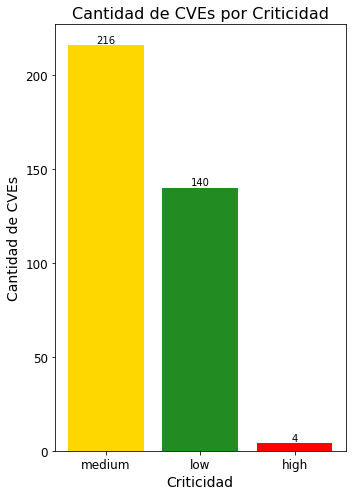

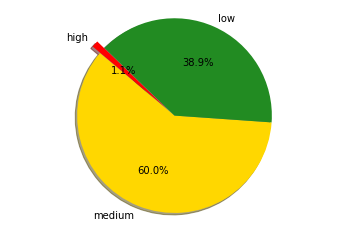

In [8]:
# Se importa la clase defaultdict para crear diccionarios con valores predeterminados
from collections import defaultdict
# Se importa el módulo pyplot para crear los gráficos
import matplotlib.pyplot as plt

# Se define la consulta SQL para obtener los datos de las vulnerabilidades de la base de datos
query = "SELECT c.vulnerabilidades FROM c"
# Se ejecuta la consulta y se almacenan los resultados en una variable
query_results = list(container.query_items(query=query, enable_cross_partition_query=True))

# Se inicializa un diccionario para almacenar la cantidad de CVEs por criticidad
cve_counts = defaultdict(int)

# Se itera sobre los resultados de la consulta
for result in query_results:
    # Se obtiene la lista de las vulnerabilidades del resultado
    vulnerabilities = result['vulnerabilidades']
    # Se realiza un for para iterar sobre cada vulnerabilidad de la lista
    for vulnerability in vulnerabilities:
        # Se obtiene la criticidad de la vulnerabilidad y se incrementa el conteo de la criticidad en
        # el diccionario 
        criticidad = vulnerability['criticidad']
        cve_counts[criticidad] += 1

# Se crea una lista ordenada de colores para las barras
colores = ['gold', 'forestgreen', 'red', 'orange', 'violet']

# Se crea la gráfica de barras especificando el tamaño 
plt.figure(figsize=(5, 7))
# Se crean las barras con la función bar y se especifican los colores
bars = plt.bar(cve_counts.keys(), cve_counts.values(), color=colores)

# Se itera sobre las barras para agregar las etiquetas
for bar in bars:
    # Se obtiene la altura de la barra
    height = bar.get_height()
    # Se agrega el valor de la altura como una etiqueta en la parte superior de cada una
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height), ha='center', va='bottom')

# Se agregan las etiquetas del eje x y del eje y, el título de la gráfica y el tamaño de las etiquetas
plt.xlabel('Criticidad', fontsize=14)
plt.ylabel('Cantidad de CVEs', fontsize=14)
plt.title('Cantidad de CVEs por Criticidad', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Se ajusta el diseño de la gráfica y finalmente se muestra
plt.tight_layout()
plt.show()

explode = (0, 0, 0.1)
# Se crea la gráfica de torta
plt.pie(cve_counts.values(),explode=explode, labels=cve_counts.keys(), colors=colores, autopct='%1.1f%%', shadow=True, startangle=140)
# Se asegura de que la gráfica se muestre como un círculo
plt.axis('equal')
# Se muestra la gráfica
plt.show()


